In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import dateutil.parser
import numpy as np
import math

from tqdm import tqdm
from datetime import datetime, timedelta
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from pandas.plotting import table

In [2]:
tqdm.pandas()

In [3]:
# change to produce the results for positions [TOP_POSITION - 9 to TOP_POSITION]
TOP_POSITION = 10

In [4]:
billboard_hot_100 = pd.read_csv("../billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)
billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year
billboard_hot_100 = billboard_hot_100[(billboard_hot_100["year"] >= 1959) & (billboard_hot_100["year"] <= 2022)]
billboard_hot_100.head()

,Unnamed: 0,first_day_of_the_week,artist,song_name,position,last_week_position,peak_position,weeks_on_chart,songwriters,producers,promotion_label,year
1611,1611,1959-01-12,The Chipmunks With David Seville,The Chipmunk Song,1,1.0,1,7,Not Listed,Not Listed,Liberty,1959
1615,1615,1959-01-05,The Chipmunks With David Seville,The Chipmunk Song,1,1.0,1,6,Not Listed,Not Listed,Liberty,1959
1628,1628,1959-01-12,The Platters,Smoke Gets In Your Eyes,2,2.0,2,9,"O.Harbach, J.Kern",Not Listed,Mercury,1959
1629,1629,1959-01-12,Connie Francis,My Happiness,3,6.0,3,6,"B.Bergantine, B.Peterson",Not Listed,MGM,1959
1630,1630,1959-01-12,Billy Grammer,Gotta Travel On,4,9.0,4,8,"P.Clayton, L.Ehrlich, R.Gilbert, L.Hays, F.Hel...",Not Listed,Monument,1959


In [5]:
plt.rcParams.update({'font.size': 15})

In [6]:
billboard_hot_100["top_position"] = billboard_hot_100.groupby(
    ["artist", "song_name"])["position"].transform("min")

In [7]:
def get_past_weeks(row):
    top_position = row["top_position"].iloc[0]
    # take first day of the week when the song was in top position
    top_position_time = row[
        (row["position"] == top_position)]["first_day_of_the_week"].values[0]
    past_weeks = row[
        (row["first_day_of_the_week"] <= top_position_time)]["weeks_on_chart"].max()
    return past_weeks

def get_future_weeks(row):
    top_position = row["top_position"].iloc[0]
    past_weeks = row["past_weeks"].iloc[0]
    # take first day of the week when the song was in top position
    top_position_time = row[
        (row["position"] == top_position)]["first_day_of_the_week"].values[0]
    max_weeks = row[
        (row["first_day_of_the_week"] > top_position_time)]["weeks_on_chart"].max()
    if max_weeks is np.nan or max_weeks == 0:
        return 0
    future_weeks = max_weeks - past_weeks
    if future_weeks is np.nan or future_weeks < 0:
        return 0
    return future_weeks

In [8]:
df_past_weeks = billboard_hot_100.groupby(["artist", "song_name"]).progress_apply(
    lambda row: get_past_weeks(row)).rename("past_weeks").reset_index()

billboard_hot_100 = billboard_hot_100.merge(df_past_weeks[["artist", "song_name", "past_weeks"]], on=["artist", "song_name"], how="left")

df_future_weeks = billboard_hot_100.groupby(["artist", "song_name"]).progress_apply(
    lambda row: get_future_weeks(row)).rename("future_weeks").reset_index()

billboard_hot_100 = billboard_hot_100.merge(df_future_weeks[["artist", "song_name", "future_weeks"]], on=["artist", "song_name"], how="left")

100%|██████████| 30147/30147 [01:02<00:00, 485.96it/s]


In [9]:
billboard_hot_100["max_weeks_on_chart"] = billboard_hot_100.groupby(["artist", "song_name"])["weeks_on_chart"].transform("max")

billboard_hot_100["first_position"] = billboard_hot_100.sort_values(
    by="first_day_of_the_week").groupby(["artist", "song_name"])["position", "first_day_of_the_week"].transform("first")["position"]
billboard_hot_100["last_position"] = billboard_hot_100.sort_values(
    by="first_day_of_the_week").groupby(["artist", "song_name"])["position", "first_day_of_the_week"].transform("last")["position"]

C:\Users\cutie\AppData\Local\Temp\ipykernel_2664\3272273204.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  billboard_hot_100["first_position"] = billboard_hot_100.sort_values(
C:\Users\cutie\AppData\Local\Temp\ipykernel_2664\3272273204.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  billboard_hot_100["last_position"] = billboard_hot_100.sort_values(


In [10]:
billboard_hot_100_copy = billboard_hot_100.copy()
billboard_hot_100 = billboard_hot_100.groupby(
    ["artist", "song_name"])["past_weeks", "top_position", "future_weeks", "max_weeks_on_chart", "year", "first_position", "last_position"].first().reset_index()

C:\Users\cutie\AppData\Local\Temp\ipykernel_2664\4046987392.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  billboard_hot_100 = billboard_hot_100.groupby(


In [11]:
billboard_hot_100 = billboard_hot_100[(billboard_hot_100["year"] >= 1959) & (billboard_hot_100["year"] <= 2022)]
billboard_hot_100 = billboard_hot_100[(billboard_hot_100["top_position"] <= TOP_POSITION) & (billboard_hot_100["top_position"] >= TOP_POSITION - 9)]

## Clustering the songs based on the features for songs in top 10

In [12]:
# https://napsterinblue.github.io/notes/machine_learning/unsupervised/basic_evaluation_metrics/
def wss_score(model, X):
    sse = 0
    centroids = model.cluster_centers_    

    for point in X:
        centroid = centroids[model.predict(point.reshape(1, -1))]
        sse += np.linalg.norm((centroid - point))
    
    return sse

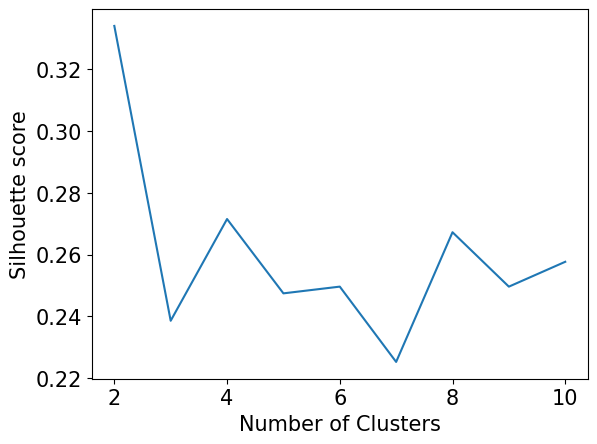

In [13]:
features = ["past_weeks", "top_position", "future_weeks", "max_weeks_on_chart", "first_position", "last_position"]

from sklearn.metrics import silhouette_score

sil = []
kmax = 10

for k in range(2, kmax+1):
    scaler = StandardScaler()
    X = scaler.fit_transform(billboard_hot_100[features])
    kmeans = KMeans(n_clusters = k, n_init="auto").fit(X)
    labels = kmeans.labels_
    sil.append(silhouette_score(X, labels, metric = 'euclidean'))

plt.plot(range(2, kmax + 1), sil)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette score")
plt.savefig(f"figures\silhouette_score_{TOP_POSITION}.pdf", format="pdf", bbox_inches="tight")
plt.show()

100%|██████████| 13/13 [00:19<00:00,  1.49s/it]


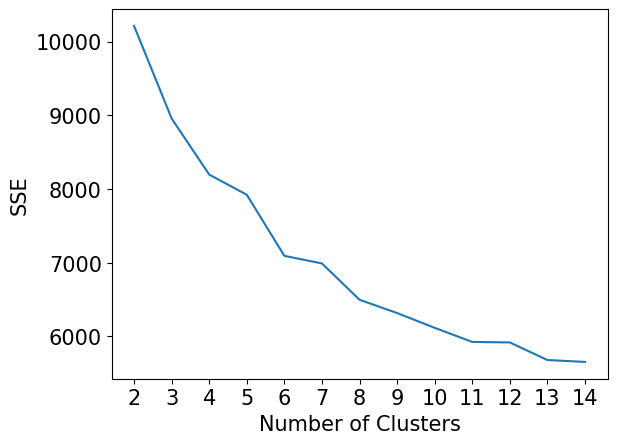

In [14]:
features = ["past_weeks", "top_position", "future_weeks", "max_weeks_on_chart", "first_position", "last_position"]

sse = []
for k in tqdm(range(2, 15)):
    kmeans = KMeans(n_clusters=k, n_init="auto")
    scaler = StandardScaler()
    X = scaler.fit_transform(billboard_hot_100[features])
    kmeans.fit(X)
    sse.append(wss_score(kmeans, X))

plt.plot(range(2, 15), sse)
plt.xticks(range(2, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.savefig(f"figures/kmeans_sse_top_{TOP_POSITION}.pdf", format="pdf")
plt.show()

In [15]:
scaler = StandardScaler()
X = scaler.fit_transform(billboard_hot_100[features])

model = KMeans(n_clusters=2, n_init="auto")
model.fit(X)

y_clusters = model.predict(X)

In [16]:
billboard_hot_100["cluster"] = y_clusters
billboard_hot_100_new = billboard_hot_100[["artist", "song_name", "cluster"]].merge(billboard_hot_100_copy, on=["artist", "song_name"], how="left")

In [17]:
from numpy import unique

unique_clusters = unique(y_clusters)

In [18]:
# classify clusters
cluster_statistics = {}

for cluster in unique_clusters:
    songs_from_cluster = billboard_hot_100_new[billboard_hot_100_new['cluster'] == cluster].copy()
    cluster_statistics[cluster] = songs_from_cluster[["weeks_on_chart", "past_weeks", "future_weeks", "first_position", "last_position", "top_position"]].describe()

longlasting_cluster = np.argmax([cluster_statistics[i].loc['75%'].loc["weeks_on_chart"] for i in unique_clusters])
print("Longlasting " + str(longlasting_cluster))

Longlasting 1


In [19]:
def map_cluster_name(cluster_nr):
    if cluster_nr == longlasting_cluster:
        return "Long-lasting songs"
    return "Other songs"

billboard_hot_100_new["cluster"] = billboard_hot_100_new["cluster"].map(lambda x: map_cluster_name(x))

In [20]:
rows_to_add = []

grouped = billboard_hot_100_new.groupby(["artist", "song_name"])

for name, group in tqdm(grouped):
    max_week = group["first_day_of_the_week"].max()

    for row_index, row in group.iterrows():
        if row["first_day_of_the_week"] == max_week:
            week = row["first_day_of_the_week"] + timedelta(weeks=1)

            while week <= (max_week + timedelta(weeks=50)):
                rows_to_add.append({
                    "artist": row["artist"],
                    "song_name": row["song_name"],
                    "weeks_on_chart": row["weeks_on_chart"],
                    "position": 101,
                    "first_day_of_the_week": week,
                    "top_position": row["top_position"],
                    "first_position": row["first_position"],
                    "last_position": row["last_position"],
                    "past_weeks": row["past_weeks"],
                    "future_weeks": row["future_weeks"],
                    "max_weeks_on_chart": row["max_weeks_on_chart"],
                    "cluster": row["cluster"],
                    "year": row["year"]
                })
                week += timedelta(weeks=1)

billboard_100_with_empty_weeks = pd.concat([billboard_hot_100_new[["artist", "song_name",
    "weeks_on_chart", "position", "first_day_of_the_week", "top_position",
    "first_position", "last_position", "past_weeks", "future_weeks",
    "max_weeks_on_chart", "cluster"]], pd.DataFrame(rows_to_add)], ignore_index=True)
billboard_100_with_empty_weeks["first_week"] = billboard_100_with_empty_weeks.groupby(["artist", "song_name"])["first_day_of_the_week"].transform("min")

100%|██████████| 5056/5056 [00:24<00:00, 209.18it/s]


100%|██████████| 2/2 [00:10<00:00,  5.42s/it]


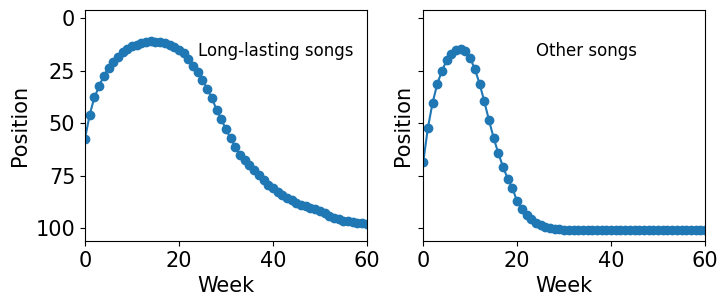

In [21]:
fig, axes = plt.subplots(math.ceil(len(unique_clusters)/2), 2, figsize=(8, 3), sharex=True, sharey=True)
row_i, col_i = 0, 0
unique_clusters = unique(billboard_100_with_empty_weeks['cluster'])

for cluster in tqdm(unique_clusters):
    songs_from_cluster = billboard_100_with_empty_weeks[billboard_100_with_empty_weeks['cluster'] == cluster].copy()

    min_first_week = songs_from_cluster["first_day_of_the_week"].min().to_pydatetime()

    songs_from_cluster["first_day_of_the_week"] = songs_from_cluster.apply(lambda row:
        int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

    songs_from_cluster.set_index("first_day_of_the_week", inplace=True)
    songs_from_cluster.sort_index(inplace=True)

    axes[col_i].plot(songs_from_cluster.groupby("first_day_of_the_week")["position"].mean(),
            marker='o')

    axes[col_i].text(0.4, 0.8, f"{cluster}", transform=axes[col_i].transAxes, fontsize=12)
    axes[col_i].set_xlabel("Week")
    axes[col_i].set_ylabel("Position")

    col_i += 1

plt.xlim(0, 60)
plt.gca().invert_yaxis()
plt.savefig(f"figures/average_cluster_trajectories_top_{TOP_POSITION}.pdf", format="pdf", bbox_inches='tight')
plt.show()

100%|██████████| 2000/2000 [00:02<00:00, 765.60it/s]


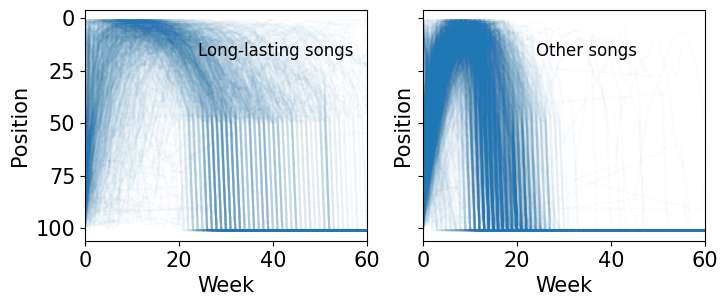

In [22]:
fig, axes = plt.subplots(math.ceil(len(unique_clusters)/2), 2, figsize=(8, 3), sharex=True, sharey=True)
row_i, col_i = 0, 0

for cluster in unique_clusters:
    songs_from_cluster = billboard_100_with_empty_weeks[billboard_100_with_empty_weeks['cluster'] == cluster].copy()
        
    min_first_week = songs_from_cluster["first_day_of_the_week"].min().to_pydatetime()

    songs_from_cluster["first_day_of_the_week"] = songs_from_cluster.apply(lambda row:
        int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

    songs_from_cluster = songs_from_cluster[songs_from_cluster["first_day_of_the_week"] < 80]
    songs_from_cluster.set_index("first_day_of_the_week", inplace=True)
    songs_from_cluster.sort_index(inplace=True)

    first_2000_songs = [g[1] for g in list(songs_from_cluster.groupby(["artist", "song_name"]))[:2000]]
    for song in tqdm(first_2000_songs):
        song_series = song["position"]
        axes[col_i].plot(song_series.index, song_series.values, alpha=0.02, color="C0")
        
    axes[col_i].text(0.4, 0.8, f"{cluster}", transform=axes[col_i].transAxes, fontsize=12)
    axes[col_i].set_xlabel("Week")
    axes[col_i].set_ylabel("Position")

    col_i += 1
 
plt.xlim(0, 60)
plt.gca().invert_yaxis()
plt.savefig(f"figures/cluster_trajectories_top_{TOP_POSITION}.pdf", format="pdf", bbox_inches='tight')
plt.show()

## Percentage of each cluster in time

In [23]:
# Spotify creation date
spotify_creation_date = pd.to_datetime("2008-01-01", infer_datetime_format=True)

# Youtube creation date
youtube_creation_date = pd.to_datetime("2005-02-14", infer_datetime_format=True)

# Apple music creation date
apple_music_creation_date = pd.to_datetime("2015-06-30", infer_datetime_format=True)

# CDs creation date
cds_creation_date = pd.to_datetime("1982-08-17", infer_datetime_format=True)

# MP3 creation date
mp3_creation_date = pd.to_datetime("1991-12-01", infer_datetime_format=True)

# iTunes release date
itunes_creation_date = pd.to_datetime("2001-01-09", infer_datetime_format=True)

# Cassettes creation date
cassettes_creation_date = pd.to_datetime("1963-08-30", infer_datetime_format=True)

# MTV Launch date
mtv_launch_date = pd.to_datetime("1981-08-01", infer_datetime_format=True)

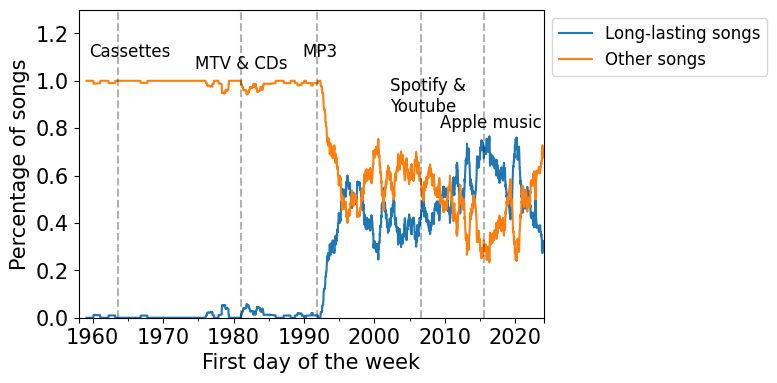

In [24]:
billboard_100_with_empty_weeks_full_data = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["year"] >= 1959) & (billboard_100_with_empty_weeks["year"] <= 2022)]
billboard_100_with_empty_weeks_full_data.groupby(["first_day_of_the_week"])["cluster"].value_counts(
    normalize=True).unstack(fill_value=0).stack().sort_index().unstack().plot(figsize=(6, 4))

plt.axvline(x = youtube_creation_date + timedelta(days=(spotify_creation_date - youtube_creation_date).days/2),
                                color='black', ls="dashed", alpha=0.3)
plt.axvline(x = apple_music_creation_date, color='black', ls="dashed", alpha=0.3)
plt.axvline(x = mtv_launch_date + timedelta(days=(mtv_launch_date - cds_creation_date).days/2), color='black',
                                ls="dashed", alpha=0.3)
plt.axvline(x = mp3_creation_date, color='black', ls="dashed", alpha=0.3)
plt.axvline(x = cassettes_creation_date, color="black", ls="dashed", alpha=0.3)

plt.text(youtube_creation_date - timedelta(weeks=150), 0.87, "Spotify &\nYoutube", fontsize=12)
plt.text(apple_music_creation_date - timedelta(weeks=320), 0.8, "Apple music", fontsize=12)
plt.text(mtv_launch_date - timedelta(weeks=370), 1.05, "MTV & CDs", fontsize=12)
plt.text(mp3_creation_date - timedelta(weeks=110), 1.1, "MP3", fontsize=12)
plt.text(cassettes_creation_date - timedelta(weeks=220), 1.1, "Cassettes", fontsize=12)

plt.ylabel("Percentage of songs")
plt.xlabel("First day of the week")
plt.xlim(datetime(1958, 1, 1), datetime(2024, 1, 1))
plt.ylim(0, 1.3)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=12)
plt.savefig(f"figures/percentage_of_songs_by_cluster_top_{TOP_POSITION}.pdf", format="pdf", bbox_inches='tight')
plt.show()

Cluster Long-lasting songs
       weeks_on_chart  past_weeks  future_weeks  first_position  \
count      878.000000  878.000000    878.000000      878.000000   
mean        35.892938   13.381549     22.511390       57.351936   
std          9.993038    7.973101      8.316802       32.657901   
min         20.000000    1.000000      0.000000        1.000000   
25%         29.000000    8.000000     16.250000       26.250000   
50%         33.000000   13.000000     21.000000       66.000000   
75%         41.000000   17.000000     27.000000       85.000000   
max         91.000000   60.000000     73.000000      100.000000   

       last_position  top_position  
count     878.000000    878.000000  
mean       46.046697      3.444191  
std         9.967283      2.592588  
min         1.000000      1.000000  
25%        44.000000      1.000000  
50%        47.000000      3.000000  
75%        49.000000      5.000000  
max       100.000000     10.000000  
Cluster Other songs
       weeks_on_

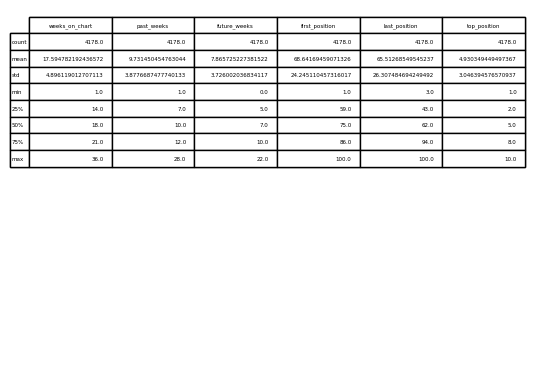

In [25]:
for cluster in unique_clusters:
    songs_from_cluster = billboard_100_with_empty_weeks_full_data[billboard_100_with_empty_weeks_full_data['cluster'] == cluster].copy()
    print(f"Cluster {cluster}")
    cluster_subdf = songs_from_cluster[["artist", "song_name", "weeks_on_chart", "past_weeks", "future_weeks", "first_position", "last_position", "top_position"]].drop_duplicates()
    cluster_describe = cluster_subdf[["weeks_on_chart", "past_weeks", "future_weeks", "first_position", "last_position", "top_position"]].describe()
    print(cluster_describe)

    #https://stackoverflow.com/questions/48158688/save-pandas-describe-for-human-readibility
    #create a subplot without frame
    plot = plt.subplot(111, frame_on=False)

    #remove axis
    plot.xaxis.set_visible(False) 
    plot.yaxis.set_visible(False) 

    #create the table plot and position it in the upper left corner
    table(plot, cluster_describe, loc='upper right')
    #save the plot as a png file
    plt.savefig(f'figures/top_{TOP_POSITION}_cluster_{cluster}.pdf', format="pdf")


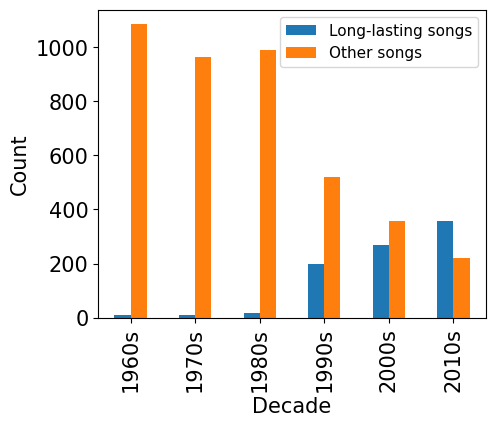

In [26]:
billboard_hot_100_new["year"] = billboard_hot_100_new["first_day_of_the_week"].dt.year
billboard_hot_100_new["decade"] = billboard_hot_100_new["year"].apply(lambda x: x - x % 10).map(str) + "s"
billboard_hot_100_new = billboard_hot_100_new[(billboard_hot_100_new["decade"] != "2020s") &\
                                                (billboard_hot_100_new["decade"] != "1950s")].copy()

billboard_hot_100_new[["decade", "cluster", "song_name", "artist"]].drop_duplicates().groupby(
    "decade")["cluster"].value_counts().unstack().plot(kind="bar", figsize=(5, 4))

plt.ylabel("Count")
plt.xlabel("Decade")
plt.legend(fontsize=11)
plt.savefig(f"figures/cluster_count_by_decade_{TOP_POSITION}.pdf", format="pdf", bbox_inches="tight")
plt.show()